In [1]:
from PIL import Image
from unet import Unet
from train import config
from torchvision import transforms
from tqdm import tqdm
import os
import random
import torch

In [13]:
jpg_path = "images/datasetnew/JPEGImages"
random.sample(os.listdir(jpg_path), 1)

['IMG_20210222_54_5_2.jpg']

In [4]:
def predict(pic=None, is_display=True):
    jpg_path = "images/datasetnew/JPEGImages"
    png_path = "images/datasetnew/SegmentationClassPNG"
    model_path = "./model/32/May01_18-52_Adam.pth"

    if pic:
        if not os.path.exists(os.path.join(jpg_path, pic + ".jpg")):
            raise OSError(f"{pic}图片不存在")
    else:
        pic = random.sample(os.listdir(jpg_path), 1)[0].split(".")[0]
        
    with open("images/test.txt", "r") as f:
        test = f.readlines()
    test = [img.strip() for img in test]
    img_type = "test" if pic in test else "train"
        
    jpg_img = Image.open(os.path.join(jpg_path, pic + ".jpg"))
    png_img = Image.open(os.path.join(png_path, pic + ".png"))
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print(f"predicting on {device}...")
    model = Unet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    jpg_img = config["transforms"]["val"]["l"](jpg_img) if jpg_img.size[0] == 1604 else\
              config["transforms"]["val"]["s"](jpg_img)
    png_img = config["transforms"]["val"]["l"](png_img) if png_img.size[0] == 1604 else\
              config["transforms"]["val"]["s"](png_img)
    x = transforms.ToTensor()(jpg_img)
    x = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(x)
    
    p = model(x.unsqueeze(0))
    p = torch.argmax(p, dim=1).type(torch.float32)
    gt = transforms.ToTensor()(png_img)
    iou = 100 * ((p * gt) != 0).sum() / ((p + gt) != 0).sum()
    
    
    
    if is_display:
        p = transforms.ToPILImage()(p).convert("RGB")
        png_img = png_img.convert("RGB")
        img1 = Image.blend(jpg_img, png_img, 0.3)
        img2 = Image.blend(jpg_img, p, 0.3)
        display(img1)
        display(img2)
        
    return iou, pic, img_type

In [ ]:
txt_path = "images/test.txt"
with open(txt_path, "r") as f:
    images = f.readlines()
images = [img.strip() for img in images]
sum_iou = 0
for img in tqdm(images):
    iou, _ = predict(img, False)
    sum_iou += iou
print(sum_iou / len(images))

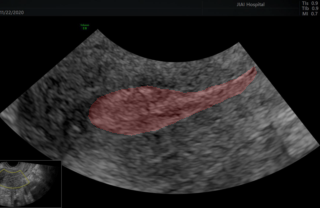

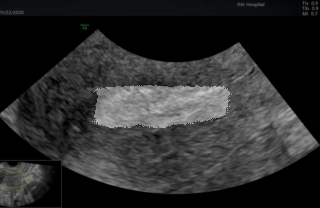

tensor(67.5142)
train
IMG_20210222_10_4_2


In [7]:
iou, pic, t = predict()
print(iou)
print(t)
print(pic)

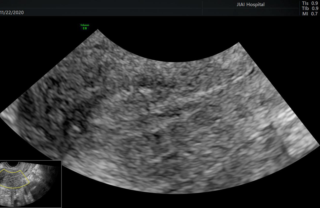

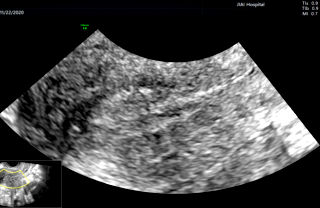

In [35]:
path = "images/datasetnew/JPEGImages/IMG_20210222_10_4_2.jpg"
img = Image.open(path)
img = config["transforms"]["val"]["l"](img) if img.size[0] == 1604 else\
      config["transforms"]["val"]["s"](img)
after = transforms.ColorJitter(contrast=1)(img)
display(img)
display(after)

In [3]:
jpg_path = "images/datasetnew/JPEGImages"

max_iou, min_iou = 0, 100
max_pic, min_pic = None, None
for pic in tqdm(os.listdir(jpg_path)):
    pic = pic.split(".")[0]
    iou, pic_name = predict(pic=pic, is_display=False)
    if iou > max_iou:
        max_iou = iou
        max_pic = pic_name
    if iou < min_iou:
        min_iou = iou
        min_pic = pic_name

100%|███████████████████████████████████████| 971/971 [3:15:49<00:00, 12.10s/it]


In [4]:
max_iou, min_iou

(tensor(81.1711), tensor(0.3116))

In [28]:
iou, pic = predict(max_pic)
print("max:", iou, pic)
iou, pic = predict(min_pic)
print("min:", iou, pic)

NameError: name 'max_pic' is not defined

In [27]:
print(pic)

IMG_20210222_33_8_2


In [28]:
import time
 
tm = time.localtime(time.time())
model = str(tm.tm_mon) + "-" + str(tm.tm_mday) + "_" + str(tm.tm_hour)\
                       + ":" + str(tm.tm_min) + "_model.pth"
model

'4-29_18:19_model.pth'